# Alpha - Beta calculation with initial velocity determination

This notebook allows you to calculate the basic dimensionless alpha - beta parameters for a set of fireball data after [Gritsevich 2012](https://doi.org/???). This use the exponential atmosphere simplification. To use a complete atmosphere model for your fireball, please see [Lyytinen et al. 2016](https://doi.org/10.1016/j.pss.2015.10.012).

It also allows you to determine the initial velocity as well as manually fit all three parameters for difficult cases. 


### Inputs:
csv file with following column headers:
+ velocity (or as indicated below)
+ height (or as indicated below)

### Outputs:
ecsv file with:
+ normalised height 
+ normalised velocity 
+ alpha and beta in metadata

# Table of Contents
preliminary sections

[Code imports](#imports)

[Function definitions](#functions)

[Data uploads](#data)
    


[Section 1](#section_1) Calculate and plot $\alpha$ and $\beta$ values

&nbsp;&nbsp;&nbsp;&nbsp;[Section 1.1](#section_1p1) Normalising data

&nbsp;&nbsp;&nbsp;&nbsp;[Section 1.2](#section_1p2) Calculate $\alpha$ and $\beta$ values

&nbsp;&nbsp;&nbsp;&nbsp;[Section 1.3](#section_1p3) Plotting


[Section 2](#section_2) Calculate and plot $\alpha$, $\beta$ and $V_0$ values

&nbsp;&nbsp;&nbsp;&nbsp;[Section 2.1](#section_2p1) Smoothing data

&nbsp;&nbsp;&nbsp;&nbsp;[Section 2.2](#section_2p2) Calculate $\alpha$ and $\beta$ values

&nbsp;&nbsp;&nbsp;&nbsp;[Section 2.3](#section_2p3) Plotting




[Section 3](#section_3) Manipulate $\alpha$, $\beta$ and $V_0$ values manually

&nbsp;&nbsp;&nbsp;&nbsp;[Section 3.1](#section_3p1) interactive $\alpha$, $\beta$ and $V_0$ determination

&nbsp;&nbsp;&nbsp;&nbsp;[Section 3.2](#section_3p2) Interactive mass determination


###########################################################
## DO NOT change this section
Please just run the cells as they are.  To run code cells, select and press shift + enter

<a id=’imports’></a>
## Code imports
Let's start with code imports. To run code cells, select and press shift + enter

In [156]:
# import astropy
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, basinhopping
from astropy.table import Table, vstack
from astropy import units as u
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os, glob
from IPython.display import FileLinks, FileLink, DisplayObject
import warnings
warnings.filterwarnings('ignore')

In [157]:
matplotlib inline

In [158]:
plt.rcParams['figure.dpi'] = 100

<a id=’functions’></a>
##  Function definitions

In [159]:
def Q4_min(vvals, yvals, err=[]):
    """ initiates and calls the Q4 minimisation given in Gritsevich 2007 -
        'Validity of the photometric formula for estimating the mass of a fireball projectile'
    """
    b0 = 1.
    a0 = np.exp(Yvalues[-1])/(2. * b0)
    x0 = [a0, b0]
    xmin = [0.01, 0.0001]
    xmax = [1000., 20.]

    bnds = ((xmin[0], xmax[0]), (xmin[1], xmax[1]))

    res = minimize(min_fun, x0, args=(vvals, yvals, err),bounds=bnds)
    out = res.x
    
    return out   

def min_fun(x, vvals, yvals,err):
    """minimises equation 7 using Q4 minimisation given in equation 10 of 
       Gritsevich 2007 - 'Validity of the photometric formula for estimating 
       the mass of a fireball projectile'

    """ 
    res = []
    for i in range(len(vvals)):
        vval = vvals[i]
        res.append(pow(2 * x[0] * np.exp(-yvals[i]) - (scipy.special.expi(x[1]) - scipy.special.expi(x[1]* vval**2) ) * np.exp(-x[1]) , 2))
 
    return np.nansum(res) 

In [160]:
def Q4_min_v(velocities, heights, h0, V0, err=[]):
    """ initiates and calls the Q4 minimisation given in Gritsevich 2007 -
        'Validity of the photometric formula for estimating the mass of a fireball projectile'
    """
    Yvalues = [j / h0 for j in heights] # normalisation of heights here
    b0 = 0.01
    a0 = np.exp(Yvalues[-1])/(2. * b0)
    x0 = [a0, b0, V0/1000]
    xmin = [0.01, 0.0001, V0 * 0.95/1000] # /1000 is a hack to make velocities small so minimisation doesnt use stupid steps
    xmax = [1000., 20., V0 * 1.05/1000]

    bnds = ((xmin[0], xmax[0]), (xmin[1], xmax[1]), (xmin[2], xmax[2]))

    res = minimize(min_fun_v, x0, args=(velocities, Yvalues, err),bounds=bnds)
    out = res.x
    out[2]*=1000. # fix velocities for return
    return out   

def min_fun_v(x, velocities, yvals,err):
    """minimises equation 7 using Q4 minimisation given in equation 10 of 
       Gritsevich 2007 - 'Validity of the photometric formula for estimating 
       the mass of a fireball projectile'

    """ 
    res = []
    for i in range(len(velocities)):
        vval = velocities[i] / (x[2]*1000.)
        res.append(pow(2 * x[0] * np.exp(-yvals[i]) - (scipy.special.expi(x[1]) - scipy.special.expi(x[1]* vval**2) ) * np.exp(-x[1]) , 2))
    return np.nansum(res)

###########################################################

<a id=’data upload’></a>
##  Upload data
Now provide the path to the csv file 

In [161]:
f1 = "DN150417.csv"
data = Table.read(f1, format='ascii.csv', guess=False, delimiter=',')
slope = 50* u.deg

If you would like to define an initial velocity, insert below. Otherwise, an average of first 10 data points will be used.

In [162]:
v0 = []

If you would like to change the default header names, insert here:

In [163]:
vel_col = "D_DT_geo"
h_col = "height"
data.sort([h_col])
data = data[::-1]

######################################################
<a id=’section_1’></a>
# Section 1
## This section calculates and plots $\alpha$ and $\beta$ values

<a id=’section_1p1’></a>
### Section 1.1 -  Normalising Data

In [164]:
alt = []
vel = []

# remove any nan values from velocity column
for v in range(len(data[vel_col])):
    if data[vel_col][v] >1.:
        vel.append(data[vel_col][v])
        alt.append(data[h_col][v])


vel = np.asarray(vel)
alt = np.asarray(alt)
        
# approximate initial velocity, if not already given
if v0 == []:
    v0 = np.nanmean(vel[0:10])

# normalise velocity
Vvalues = vel/v0      #creates a matrix of V/Ve to give a dimensionless parameter for velocity

# normalise height - if statement accounts for km vs. metres data values.
# h0 is the atmospheric scale height.
if alt[0]<1000:
    h0 = 7.160  # km
else:
    h0 = 7160.  # metres
Yvalues = alt/h0  

<a id=’section_1p2’></a>
### Section 1.2 - Calculate $\alpha$ and $\beta$ values

In [165]:
Gparams= Q4_min(Vvalues, Yvalues)

alpha = Gparams[0]
beta = Gparams[1]
print(f"alpha = {alpha}")
print(f"beta = {beta}") 
print(f"using inital velocity v0 = {v0}")
print(f"\nOther useful values:")
print(f"log alpha = {np.log(alpha)}")
print(f"log beta = {np.log(beta)}")
print(f"log(alpha sin(slope)) = {np.log(alpha * np.sin(slope))}")

alpha = 249.63712429583973
beta = 1.8055759868030987
using inital velocity v0 = 18118.32807494

Other useful values:
log alpha = 5.520008360594909
log beta = 0.5908796471433744
log(alpha sin(slope)) = 5.253493269407853


<a id=’section_1p3’></a>
### Section 1.3 - Plotting
#### plot the fit using the calculated  $\alpha$ and $\beta$ values

In [166]:
plt.close()
# plt.rcParams['figure.dpi'] = 10
plt.rcParams['figure.figsize'] = [5, 5]

In [167]:
x = np.arange(0.1,1, 0.00005);                                                                                     #create a matrix of x values
fun = lambda x:np.log(alpha) + beta - np.log((scipy.special.expi(beta) - scipy.special.expi(beta* x**2) )/2)
y = [fun(i) for i in x]

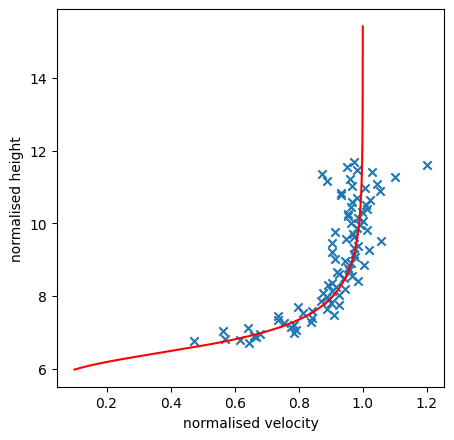

In [168]:
plt.scatter(Vvalues, Yvalues,marker='x', label=None)  
plt.xlabel("normalised velocity")
plt.ylabel("normalised height")
plt.plot(x, y, color='r')
# plt.xlim(0.4, 1.23)
# plt.ylim(6, 12)
plt.show()

#### determine the final mass, and if it lies above an expected final mass limit

In [169]:
plt.close()
print("mf = the final mass boundary limit plotted,\nmu = the shape change coefficient (2/3 for uniform ablation across the surface for high spin, 0 flow no spin and fronal ablaiton only)\ncd = the drag coefficient (1 for sphere,\nrho = the density of the meteoroid\nA = the cross sectional area to volume ratio (1.21 for sphere)\n\n")
def f(mf, mu, cd, rho, A):
    fig, axs = plt.subplots(1,1)

    rho = float(rho)
    A = float(A)
    mf = mf/1000.
    m0 = (0.5 * cd * 1.29 * 7160. * A / pow(rho, 2/3))**3.
    x = np.arange(-3,10, 0.00005)
    y = [np.log((mu - 1) * (np.log(mf/m0) + 3 * i)) for i in x]
    
    axs.plot(x, y, color='k')
    
    axs.scatter([np.log(alpha * np.sin(slope))], [np.log(beta)], color='r')
    m_txt=pow(0.5 *  cd * 1.29 * 7160. * A / (alpha * np.sin(slope) *rho**(2/3.0)), 3.0) *np.exp(-beta/(1-mu))*(1-Vvalues[-1]**2)

    axs.plot([-10, 10], [0, 0], color='grey')
    axs.plot([0, 0], [-10, 10], color='grey')

    axs.set_xlim((-1, 7))
    axs.set_ylim((-3, 4))
    axs.set_aspect('equal')
    plt.text(-1, 4.5, f"final mass given above (slider) parameters: {m_txt:.1f} kg")#, ha='center', va='center', transform=ax.transAxes)

    axs.set_xlabel("ln(alpha x sin(slope))")
    axs.set_ylabel("ln(beta)")
    plt.show()

interact(f, mf=(0, 2000, 500), mu=(0, 2/3., 1/3.), cd=(0.9, 1.5), rho=[3500,2700,1500,7000], A=[1.21, 1.5, 2.0, 3.0])


mf = the final mass boundary limit plotted,
mu = the shape change coefficient (2/3 for uniform ablation across the surface for high spin, 0 flow no spin and fronal ablaiton only)
cd = the drag coefficient (1 for sphere,
rho = the density of the meteoroid
A = the cross sectional area to volume ratio (1.21 for sphere)




interactive(children=(IntSlider(value=1000, description='mf', max=2000, step=500), FloatSlider(value=0.3333333…

<function __main__.f(mf, mu, cd, rho, A)>

######################################################
<a id=’section_2’></a>
# Section 2
##  This section calculates and plots $\alpha$, $\beta$ and $V_0$ values

<a id=’section_2p1’></a>
### Section 2.1 - smoothing data

In [170]:
alt1 = []
vel1 = []

# smooth data
for v in range(1, len(vel)-1):
    vel1.append((vel[v-1]+vel[v]+vel[v+1]) / 3)
    alt1.append(alt[v])

alt_smooth = []
vel_smooth = []   

# smooth data again
for v in range(1, len(vel1)-1):
    vel_smooth.append((vel1[v-1]+vel1[v]+vel1[v+1]) / 3)
    alt_smooth.append(alt1[v])
        
# define initial velocity, if not already
if v0 == []:
    v0 = np.nanmean(vel[0:10])

vel_smooth = np.asarray(vel_smooth)
alt_smooth = np.asarray(alt_smooth)


<a id=’section_2p2’></a>
### Section 2.2 - Calculate $\alpha$,  $\beta$ and $V_0$ values
This calls the Q4_min_v function 

In [171]:
Gparams= Q4_min_v(vel_smooth, alt_smooth, h0, v0)

alpha_2 = Gparams[0]
beta_2 = Gparams[1]
v0_calc = Gparams[2]

Yvalues = [j / h0 for j in alt]
Vvalues = [j / v0_calc for j in vel]

print(f"alpha = {alpha_2}")
print(f"beta = {beta_2}") 
print(f"v0 = {v0_calc}")


print(f"\nOther useful values:")
print(f"log alpha = {np.log(alpha)}")
print(f"log beta = {np.log(beta)}")
print(f"log(alpha sin(slope)) = {np.log(alpha * np.sin(slope))}")


alpha = 236.9584348164065
beta = 1.9425850138522684
v0 = 17937.738564339277

Other useful values:
log alpha = 5.520008360594909
log beta = 0.5908796471433744
log(alpha sin(slope)) = 5.253493269407853


<a id=’section_2p3’></a>
### Section 2.3 -  Plotting

In [172]:
plt.close()
# plt.rcParams['figure.dpi'] = 10
plt.rcParams['figure.figsize'] = [5, 5]

In [173]:
x = np.arange(0.1,1, 0.00005);                                                                                     #create a matrix of x values
fun = lambda x:np.log(alpha_2) + beta_2 - np.log((scipy.special.expi(beta_2) - scipy.special.expi(beta_2* x**2) )/2)
y = [fun(i) for i in x]

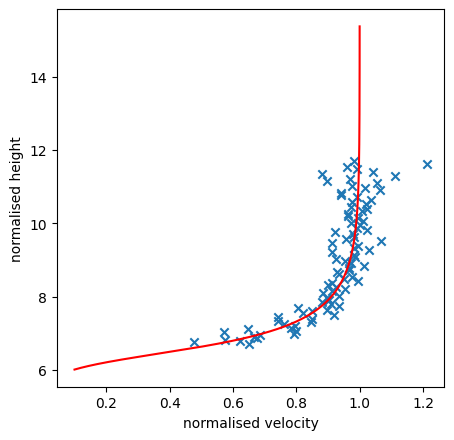

In [174]:
plt.scatter(Vvalues, Yvalues,marker='x', label=None)  
plt.xlabel("normalised velocity")
plt.ylabel("normalised height")
plt.plot(x, y, color='r')
# plt.xlim(0.4, 1.23)
# plt.ylim(6, 12)
plt.show()

#### determine the final mass, and if it lies above an expected final mass limit

In [175]:
plt.close()
print("mf = the final mass boundary limit plotted,\nmu = the shape change coefficient (2/3 for uniform ablation across the surface for high spin, 0 flow no spin and fronal ablaiton only)\ncd = the drag coefficient (1 for sphere,\nrho = the density of the meteoroid\nA = the cross sectional area to volume ratio (1.21 for sphere)\n\n")
def f(mf, mu, cd, rho, A):
    fig, axs = plt.subplots(1,1)

    rho = float(rho)
    A = float(A)
    mf = mf/1000.
    m0 = (0.5 * cd * 1.29 * 7160. * A / pow(rho, 2/3))**3.
    x = np.arange(-3,10, 0.00005)
    y = [np.log((mu - 1) * (np.log(mf/m0) + 3 * i)) for i in x]
    
    axs.plot(x, y, color='k')
    
    axs.scatter([np.log(alpha_2 * np.sin(slope))], [np.log(beta_2)], color='r')
    m_txt=pow(0.5 *  cd * 1.29 * 7160. * A / (alpha_2 * np.sin(slope) *rho**(2/3.0)), 3.0) *np.exp(-beta_2/(1-mu))*(1-Vvalues[-1]**2)

    axs.plot([-10, 10], [0, 0], color='grey')
    axs.plot([0, 0], [-10, 10], color='grey')

    axs.set_xlim((-1, 7))
    axs.set_ylim((-5, 5))
    axs.set_aspect('equal')
    plt.text(-1, 5.5, f"final mass given above (slider) parameters: {m_txt:.1f} kg")#, ha='center', va='center', transform=ax.transAxes)

    axs.set_xlabel("ln(alpha x sin(slope))")
    axs.set_ylabel("ln(beta)")
    plt.show()

interact(f, mf=(0, 2000, 500), mu=(0, 2/3., 1/3.), cd=(0.9, 1.5), rho=[3500,2700,1500,7000], A=[1.21, 1.5, 2.0, 3.0])


mf = the final mass boundary limit plotted,
mu = the shape change coefficient (2/3 for uniform ablation across the surface for high spin, 0 flow no spin and fronal ablaiton only)
cd = the drag coefficient (1 for sphere,
rho = the density of the meteoroid
A = the cross sectional area to volume ratio (1.21 for sphere)




interactive(children=(IntSlider(value=1000, description='mf', max=2000, step=500), FloatSlider(value=0.3333333…

<function __main__.f(mf, mu, cd, rho, A)>

######################################################
<a id=’section_3’></a>
# Section 3
##  This section allows you to manipulate $\alpha$, $\beta$ and $V_0$ values

<a id=’section_3p1’></a>
### Section 3.1 - interactive $\alpha$, $\beta$ and $V_0$ determination

In [176]:
plt.close()
x = np.arange(0.1,1, 0.00005);                                                                                     #create a matrix of x values


def f(V0,alpha, beta):#, mu, cd):#, rho, A):
    cd = 1
    A = 1.21
    rho = 3500
    mu =2/3.
    yvalues = [j / h0 for j in alt]
    vvalues = [j / V0 for j in vel]
    
    res = min_fun_v([alpha, beta, V0/1000.], vel, yvalues, [])
    
    plt.scatter(vvalues, yvalues,marker='x', label=None)  
    y = np.log(alpha) + beta - np.log((scipy.special.expi(beta) - scipy.special.expi(beta* x**2) )/2)
    
    plt.plot(x, y, color='k')

    rho = float(rho)
    A = float(A)
    m0 = (0.5 * cd * 1.29 * 7160. * A / pow(rho, 2/3))**3.

    
#     m_f = np.exp(-beta/(1-mu) * (1-Vvalues[-1]**2)) * pow(0.5 *  cd * 1.29 * 7160. * A / (rho**(2/3.0) *np.sin(slope) * alpha, 3))
    me_txt=pow(0.5 *  cd * 1.29 * 7160. * A / (alpha * np.sin(slope) *rho**(2/3.0)), 3.0)# *np.exp(-beta/(1-mu))*(1-vvalues[-1]**2)

    plt.text(0.2, 18.5, "residual fit = {}".format(res))
    plt.text(0.2, 18, "final mass given default parameters: %.1f g" %(me_txt * 1000) )#, ha='center', va='center', transform=ax.transAxes)
    plt.show()
    return(alpha, beta, V0)



## this line runs the interact function. It is designed to take the calculated values from previous section as inputs
## if you would like to set your own slider limits, please use the second function call line below
out = interact(f,V0=(v0_calc*.5,v0_calc*1.5, 250.), alpha=(alpha_2*.1,alpha_2*1.9, 0.25), beta=(beta_2*.5, beta_2*1.5, 0.1))



## uncomment this section if you would like to set your own slider limits
# v0_min = 
# v0_max = 
# alpha_min = 
# alpha_max = 
# beta_min = 
# beta_max = 
# out = interact(f,V0=(v0_min,v0_max, 250.), alpha=(alpha_min, alpha_max, 0.25), beta=(beta_min, beta_max, 0.1))


interactive(children=(FloatSlider(value=17718.86928216964, description='V0', max=26906.607846508916, min=8968.…

In [177]:
alpha_fit = out.widget.result[0]
beta_fit = out.widget.result[1]
v0_fit = out.widget.result[2]

<a id=’section_3p2’></a>
### Section 3.2 - interactive mass determination

In [180]:
plt.close()
print("mf = the final mass boundary limit plotted,\nmu = the shape change coefficient (2/3 for uniform ablation across the surface for high spin, 0 flow no spin and fronal ablaiton only)\ncd = the drag coefficient (1 for sphere,\nrho = the density of the meteoroid\nA = the cross sectional area to volume ratio (1.21 for sphere)\n\n")
def f(mf, mu, cd, rho, A):
    fig, axs = plt.subplots(1,1)

    rho = float(rho)
    A = float(A)
    mf = mf/1000.
    m0 = (0.5 * cd * 1.29 * 7160. * A / pow(rho, 2/3))**3.
    x = np.arange(-3,10, 0.00005)
    y = [np.log((mu - 1) * (np.log(mf/m0) + 3 * i)) for i in x]
    
    axs.plot(x, y, color='k')
    
    axs.scatter([np.log(alpha_fit * np.sin(slope))], [np.log(beta_fit)], color='r')
    m_txt=pow(0.5 *  cd * 1.29 * 7160. * A / (alpha_fit * np.sin(slope) *rho**(2/3.0)), 3.0) *np.exp(-beta_fit/(1-mu))*(1-Vvalues[-1]**2)

    axs.plot([-10, 10], [0, 0], color='grey')
    axs.plot([0, 0], [-10, 10], color='grey')

    axs.set_xlim((-1, 7))
    axs.set_ylim((-5, 5))
    axs.set_aspect('equal')
    plt.text(-1, 5.5, f"final mass given above (slider) parameters: {m_txt:.1f} kg")#, ha='center', va='center', transform=ax.transAxes)

    axs.set_xlabel("ln(alpha x sin(slope))")
    axs.set_ylabel("ln(beta)")
    plt.show()

interact(f, mf=(0, 2000, 500), mu=(0, 2/3., 1/3.), cd=(0.9, 1.5), rho=[3500,2700,1500,7000], A=[1.21, 1.5, 2.0, 3.0])


mf = the final mass boundary limit plotted,
mu = the shape change coefficient (2/3 for uniform ablation across the surface for high spin, 0 flow no spin and fronal ablaiton only)
cd = the drag coefficient (1 for sphere,
rho = the density of the meteoroid
A = the cross sectional area to volume ratio (1.21 for sphere)




interactive(children=(IntSlider(value=1000, description='mf', max=2000, step=500), FloatSlider(value=0.3333333…

<function __main__.f(mf, mu, cd, rho, A)>

## End of notebook